# CVSS Data
---

In [1]:
# Import necessary libraries
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
import warnings

# Initialize itables options
opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

# Configure warnings
warnings.filterwarnings("ignore")

# Configure pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


In [2]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2000, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

## CVSS Graph

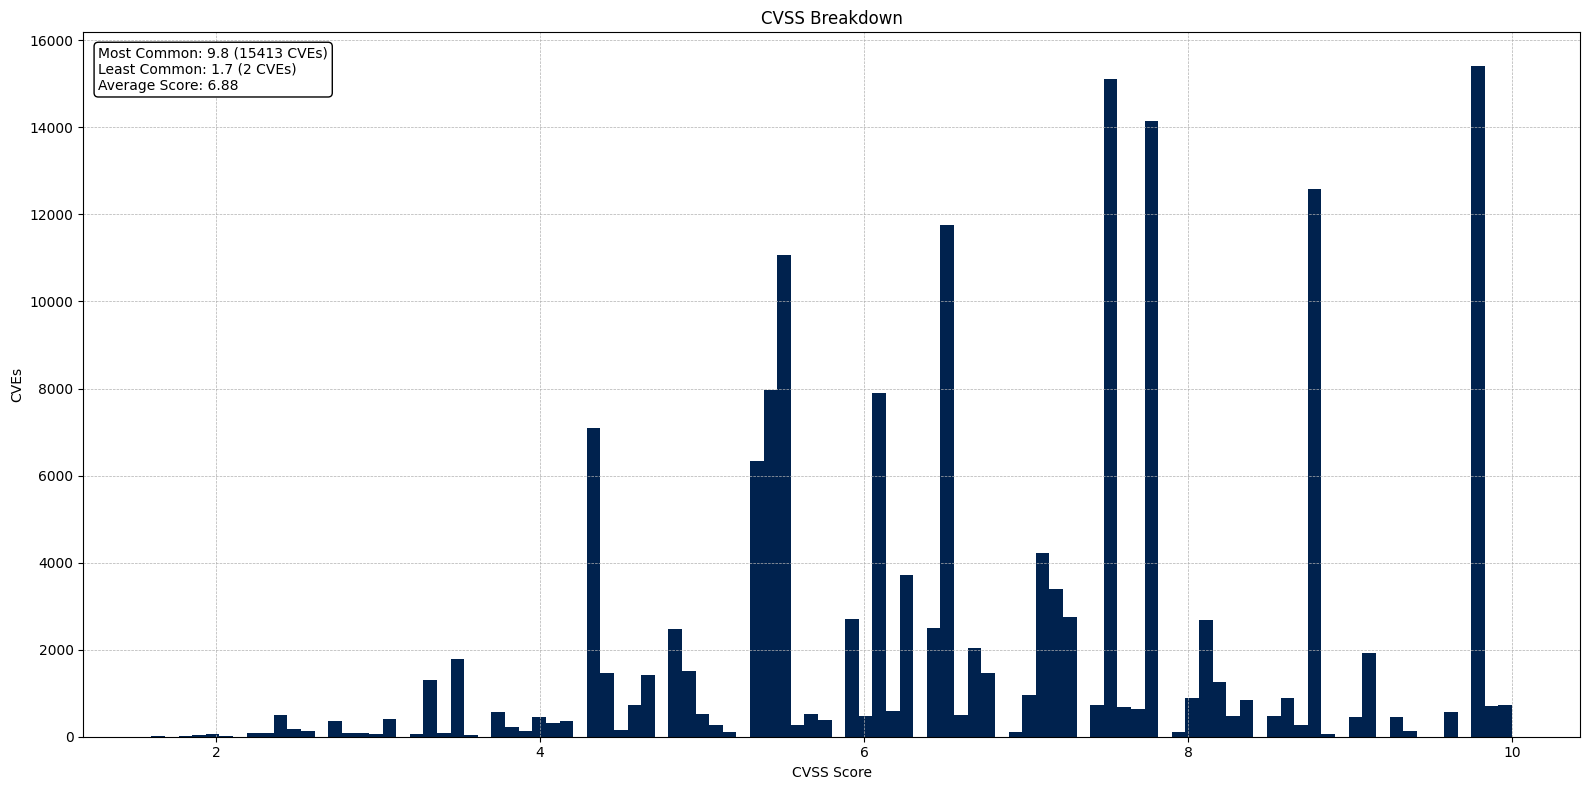

In [3]:
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore'])
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan)

# Plot the CVSS breakdown with 100 bins
cg = nvd['BaseScore'].plot(kind="hist", bins=100, title='CVSS Breakdown', colormap='cividis', figsize=(16, 8))
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("CVSS Score")

# Find the most common, least common, and average CVSS scores
most_common_score = nvd['BaseScore'].mode()[0]
least_common_score = nvd['BaseScore'].value_counts().idxmin()
most_common_count = nvd['BaseScore'].value_counts().max()
least_common_count = nvd['BaseScore'].value_counts().min()
average_score = nvd['BaseScore'].mean().round(2)

# Add annotation for the most common, least common, and average CVSS scores
annotation_text = (f'Most Common: {most_common_score} ({most_common_count} CVEs)\n'
                   f'Least Common: {least_common_score} ({least_common_count} CVEs)\n'
                   f'Average Score: {average_score}')
plt.text(0.01, 0.98, annotation_text, transform=cg.transAxes, fontsize=10, color='black',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()

## CVSS Count

In [4]:
# Define the bins and labels
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = [str(i) for i in range(1, 11)]

# Bin the 'BaseScore' values and calculate the value counts
nvd['BaseScoreBinned'] = pd.cut(nvd['BaseScore'], bins=bins, labels=labels, right=True)
base_score_counts = nvd['BaseScoreBinned'].value_counts().sort_index()

# Reset the index and rename the columns
base_score_counts = base_score_counts.reset_index()
base_score_counts.columns = ['CVSS BaseScore (Whole Number)', 'Count']

# Display the DataFrame
base_score_counts

Loading ITables v2.4.4 from the internet... (need help?)


## Vector Count

In [5]:
# Calculate the counts of Attack Vectors
attack_vector_counts = nvd['AttackVector'].value_counts().reset_index()
attack_vector_counts.columns = ['Attack Vector', 'Count']

# Display the DataFrame
attack_vector_counts

Loading ITables v2.4.4 from the internet... (need help?)


In [6]:
# Calculate the counts of Attack Vectors as percentages
attack_vector_counts = nvd['AttackVector'].value_counts(normalize=True).mul(100).round(2).reset_index()
attack_vector_counts.columns = ['Attack Vector', 'Percentage']

# Display the DataFrame
attack_vector_counts

Loading ITables v2.4.4 from the internet... (need help?)


## Yearly Breakdown

In [7]:
import pandas as pd

# Calculate the counts of Attack Vectors
attack_vector_counts = nvd['AttackVector'].value_counts().reset_index()
attack_vector_counts.columns = ['Attack Vector', 'Count']

# Display the DataFrame
attack_vector_counts

# Add a 'Year' column to the DataFrame
nvd['Year'] = nvd['Published'].dt.strftime('%Y')

# Create a new DataFrame with 'Year' and 'AttackVector'
nvd2 = nvd[['Year', 'AttackVector']].copy()

# Calculate the counts of Attack Vectors by Year
av_df = nvd2.value_counts().to_frame('AttackVectorCount').reset_index()

# Sort the DataFrame by 'Year' and 'AttackVectorCount'
av_df = av_df.sort_values(by=['Year', 'AttackVectorCount'], ascending=[False, False])

# Create a pivot table for better readability
pivot_table = av_df.pivot(index='Year', columns='AttackVector', values='AttackVectorCount').fillna(0)

# Sort the pivot table so that 2025 is on top
pivot_table = pivot_table.sort_index(ascending=False)

# Display the pivot table
pivot_table

Loading ITables v2.4.4 from the internet... (need help?)


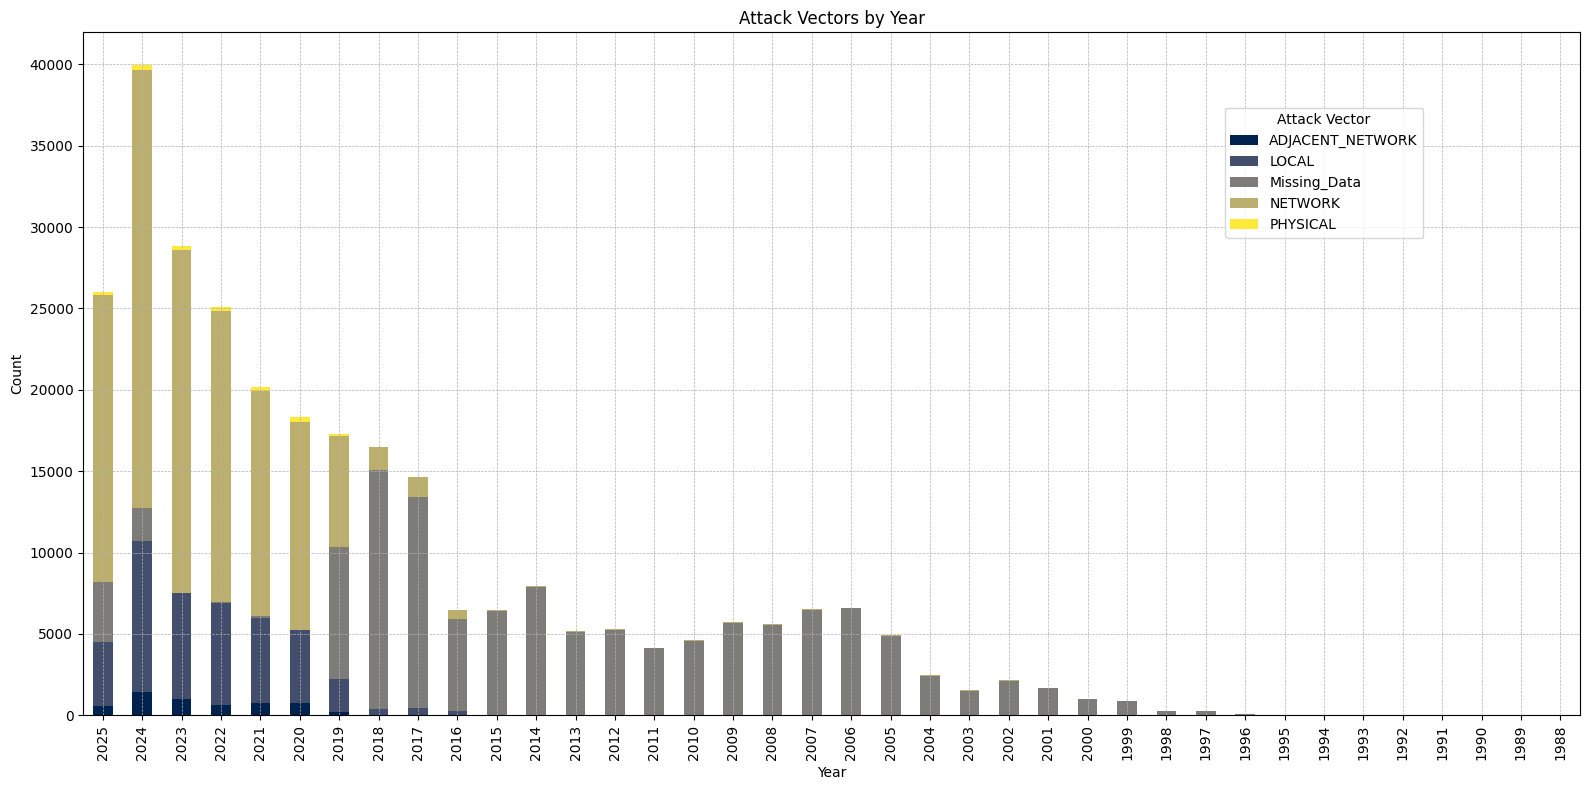

In [8]:
# Plot the pivot table
plt.figure(figsize=(16, 8))
ax = pivot_table.plot(kind='bar', stacked=True, colormap='cividis', figsize=(16, 8), ax=plt.gca())

# Customize the plot to match the style of the graphs in the rest of the repo
plt.title('Attack Vectors by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True, linestyle='--', linewidth=0.5)

# Place the legend inside the graph
ax.legend(title='Attack Vector', loc='upper right', bbox_to_anchor=(0.9, 0.9))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()